# Goal:To predict who survived the titanic disaster

# Steps:
1. Loading and data exploration.
2. Handling high cardinality
3. Filling misssing values.
4. Categorical Encoding.
5. Feature Scaling.
6. Model Bulding.
7. Selecting Best Model
8. Converting prediction to csv

NOTE:I divided my training data into x_train and x_test to understand how well the model will perform in unseen data. After getting the best model i combined the x_train and x_test to train my final model.

MODEL SUMMARY:
* The knn train data: 0.8477112010796223
* The knn test data: 0.8663235294117648
* The svc train data: 0.8504477738893749
* The svc test data: 0.7724089635854341
* The logistic reg train data: 0.8532738416554206
* The logistic reg test data is: 0.8349632352941176
* xgb training data: 0.8703606622074667
* xgb test data: 0.8045989304812835

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost
from sklearn.model_selection import cross_val_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# LOADING AND DATA EXPLORATION

In [2]:
#Lets check first 5 rows
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#bottom 5 rows
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
#lets get some statistics regarding the data
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
#lets check the shape
df.shape

(891, 12)

In [6]:
#check for null value
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
#lets check for datatype
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
#lets get the categorical variables
cat_vars = [var for var in df.columns if df[var].dtypes=='O']
cat_vars

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [9]:
#lets get the numerical variables
num_vars = [var for var in df.columns if df[var].dtypes!='O' and var!='PassengerId']
num_vars

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [10]:
#length of categorical and numerical variables
print(len(cat_vars))
print(len(num_vars))

5
6


In [11]:
#lets check for unique labels in the categorical variables
print(df['Name'].nunique())
print(df['Sex'].nunique())
print(df['Ticket'].nunique())
print(df['Cabin'].nunique())
print(df['Embarked'].nunique())

891
2
681
147
3


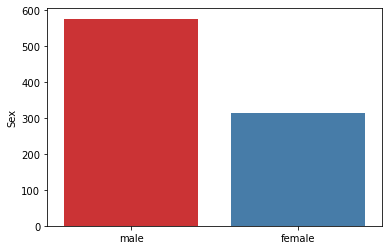

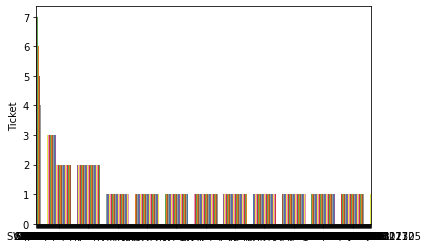

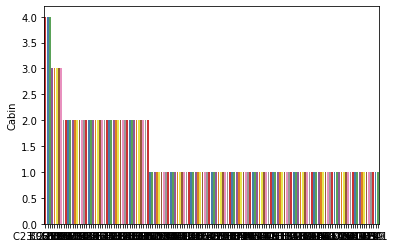

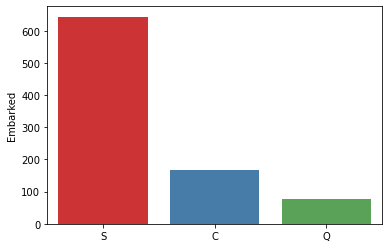

In [12]:
#NUMBER OF PEOPLE IN EACH VARIABLE
#for categorical variables
cat_vars=['Sex', 'Ticket', 'Cabin', 'Embarked']
for var in cat_vars:
    sns.barplot(x=df[var].value_counts().index,y=df[var].value_counts(),palette="Set1")
    plt.show()

graph1:The number of males is more than the number of females.
graph4:Peple embarked more from location S followed by C

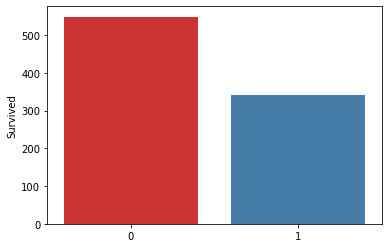

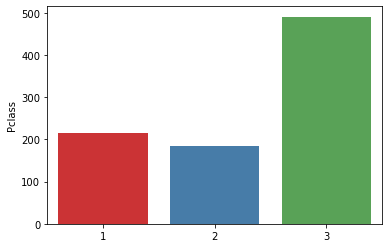

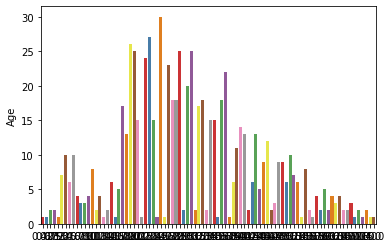

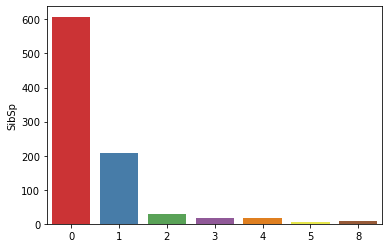

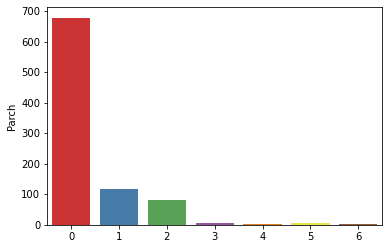

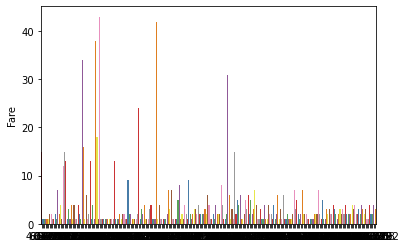

In [13]:
#for numerical varaibles
for var in num_vars:
    sns.barplot(x=df[var].value_counts().index,y=df[var].value_counts(),palette="Set1")
    plt.show()

graph1)The number of people that died where more than  people that survived
graph2)People that board with third class option where more than those with first and second class.
graph3)The age tends to be normally distributed.
graph4) Most people did not travel with siblings and spouse
grah5)Most people where without children or the children travelled with nannies.

# Relationship With Target

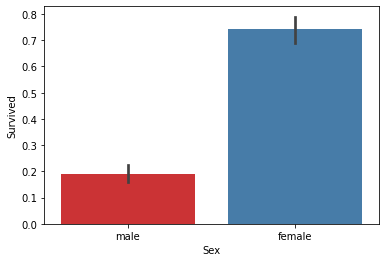

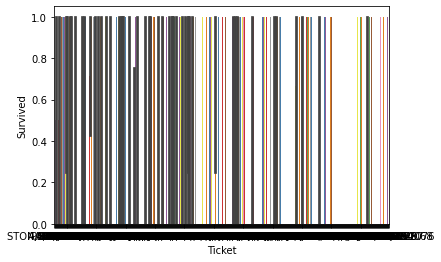

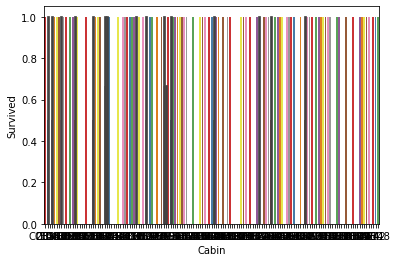

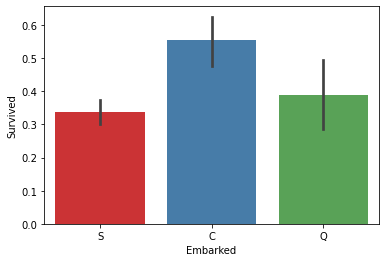

In [14]:
#for categorical variables
for var in cat_vars:
        sns.barplot(x=df[var],y=df['Survived'],palette="Set1",data=df)
        plt.show()

graph1:females had the  highier chance of survival compared to males.
graph2:people that embarked from locatonC have a highier chance of survival than other other locations

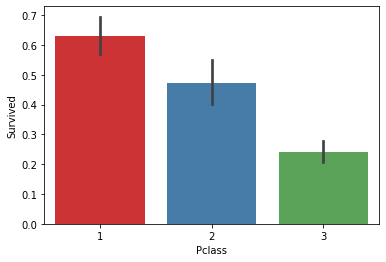

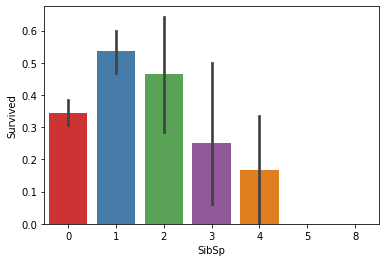

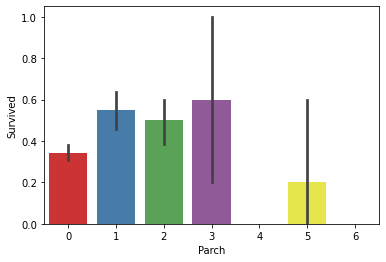

In [15]:
#for numerical variables
num_vars=['Pclass', 'SibSp', 'Parch',]
for var in num_vars:
        sns.barplot(x=df[var],y=df['Survived'],palette="Set1",data=df)
        plt.show()

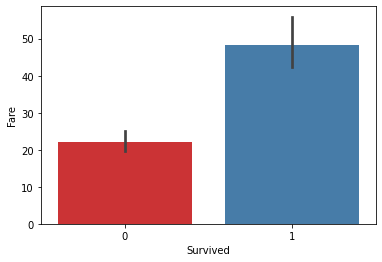

In [16]:
sns.barplot(x=df['Survived'],y=df['Fare'],palette="Set1",data=df)
plt.show()

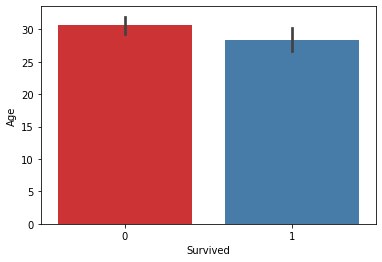

In [17]:
sns.barplot(x=df['Survived'],y=df['Age'],palette="Set1",data=df)
plt.show()

# Distribution of numerical varaibles

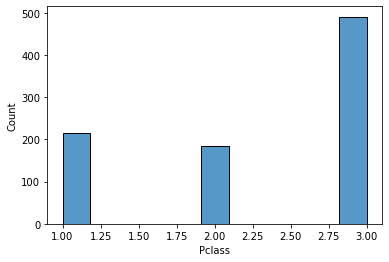

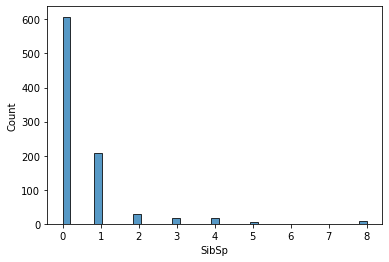

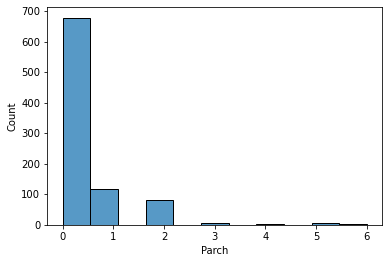

In [18]:
for var in num_vars:
    sns.histplot(df[var])
    plt.show()

Age tends to follow a normal distribution while fare is skewed left

In [19]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# HANDLING HIGH  CARDINALITY

In [20]:
print('carbin:',df['Cabin'].unique())
print('Name:',df['Name'].unique())
print('Ticket:',df['Ticket'].unique())

carbin: [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']
Name: ['Braund, Mr. Owen Harris'
 '

# Ticket

In [21]:
df['Ticket_type'] = df['Ticket'].apply(lambda x: 'single_ticket' if x.isnumeric() else 'multiple_ticket')
test['Ticket_type'] = test['Ticket'].apply(lambda x: 'single_ticket' if x.isnumeric() else 'multiple_ticket')

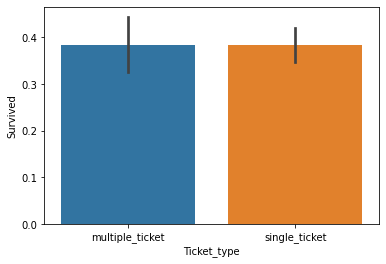

In [22]:
sns.barplot(x=df['Ticket_type'],y=df['Survived'])
plt.show()

# Cabin

In [23]:
df['Cabin'] = df['Cabin'].str[:1]
test['Cabin'] = test['Cabin'].str[:1]

In [24]:
df["Cabin"].fillna("Missing",inplace=True)
test["Cabin"].fillna("Missing",inplace=True)

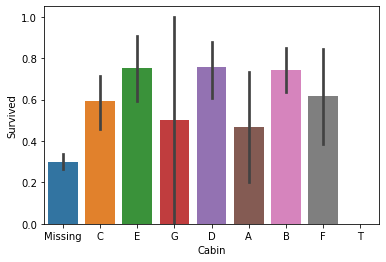

In [25]:
sns.barplot(x=df['Cabin'],y=df['Survived'])
plt.show()

# Name

In [26]:
#lets create a new feature from the name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Don', 'Jonkheer', 'Dona'], 'Royalty')
df['Title'] = df['Title'].replace(['Capt', 'Col','Dr', 'Major', 'Rev', 'Sir'], 'Sir')
df['Title'] = df['Title'].replace(['Mlle', 'Ms','Mme', 'Miss'], 'Mrs')
df['Title'] = df['Title'].replace('Master', 'Mr')

In [27]:
#lets create a new feature from the name
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Title'].replace(['Lady', 'Countess','Don', 'Jonkheer', 'Dona'], 'Royalty')
test['Title'] = test['Title'].replace(['Capt', 'Col','Dr', 'Major', 'Rev', 'Sir'], 'Sir')
test['Title'] = test['Title'].replace(['Mlle', 'Ms','Mme', 'Miss'], 'Mrs')
test['Title'] = test['Title'].replace('Master', 'Mr')

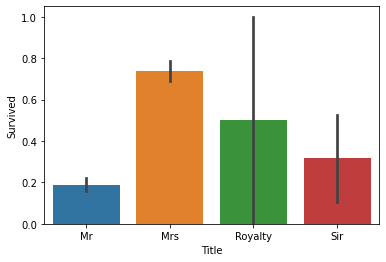

In [28]:
sns.barplot(x=df['Title'],y=df['Survived'])
plt.show()

Women survived more ,followed by royalty but ordinary males were likely to die.

In [29]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Missing,S,multiple_ticket,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,multiple_ticket,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Missing,S,multiple_ticket,Mrs
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,single_ticket,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Missing,S,single_ticket,Mr


In [30]:
df=df.drop(['Name'],axis=1)
test=test.drop(['Name'],axis=1)

In [31]:
df = df.drop(['Ticket'],axis=1)
test = test.drop(['Ticket'],axis=1)

# FILLING MISSING VALUES

In [32]:
x_train, x_test, y_train, y_test = train_test_split(
    df,
    df['Survived'], # target
    test_size=0.3, # percentage of observations in the test set
    random_state=0)

In [33]:
x_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            121
SibSp            0
Parch            0
Fare             0
Cabin            0
Embarked         2
Ticket_type      0
Title            0
dtype: int64

# AGE

In [34]:
def impute_null(df, vr, median):

    return df[vr].fillna(median)

In [35]:
median = x_train.Age.median()
median

29.0

In [36]:
x_train['Age'] = impute_null(x_train, 'Age', median)
x_test['Age'] = impute_null(x_test,'Age',median)
test['Age'] = impute_null(test,'Age',median)
test['Fare'] = impute_null(test,'Fare',median)

In [37]:
x_test.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
Ticket_type    0
Title          0
dtype: int64

# Embark

In [38]:
x_train['Embarked'].mode()

0    S
dtype: object

In [39]:
test['Embarked'].mode()

0    S
dtype: object

In [40]:
x_train['Embarked'].fillna('S', inplace=True)

In [41]:
test['Embarked'].fillna('S', inplace=True)

In [42]:
x_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
Ticket_type    0
Title          0
dtype: int64

# CATEGORICAL ENSODING

# Title

In [43]:
title_dict = {"Mr":0,'Mrs':0.5,"Royalty":0.8,"Sir":1.4}

In [44]:
x_train['Title'] = x_train['Title'].map(title_dict)
x_test['Title'] = x_test['Title'].map(title_dict)
test['Title'] = test['Title'].map(title_dict)

# Cabin

In [45]:
cabin_dict = {"B":0,'D':0,"E":0,"F":1,"C":1,'T':1,'G':1.5,"A":1.5,"Missing":1.5}

In [46]:
x_train['Cabin'] = x_train['Cabin'].map(cabin_dict) 
x_test['Cabin'] = x_test['Cabin'].map(cabin_dict) 
test['Cabin'] = test['Cabin'].map(cabin_dict)

In [47]:
x_train = pd.get_dummies(x_train,drop_first=True) 

In [48]:
x_test = pd.get_dummies(x_test,drop_first=True)
test = pd.get_dummies(test,drop_first=True)

In [49]:
x_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Cabin', 'Title', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Ticket_type_single_ticket'],
      dtype='object')

In [50]:
x_train = x_train.drop(["PassengerId"],axis=True)
x_test = x_test.drop(["PassengerId"],axis=True)

In [51]:
x_train = x_train.drop(["Survived"],axis=True)
x_test = x_test.drop(["Survived"],axis=True)

In [52]:
x_test.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,Title,Sex_male,Embarked_Q,Embarked_S,Ticket_type_single_ticket
495,3,29.0,0,0,14.4583,1.5,0.0,1,0,0,1
648,3,29.0,0,0,7.5500,1.5,0.0,1,0,1,0
278,3,7.0,4,1,29.1250,1.5,0.0,1,1,0,1
31,1,29.0,1,0,146.5208,0.0,0.5,0,0,0,0
255,3,29.0,0,2,15.2458,1.5,0.5,0,0,0,1


# FEATURE SELECTION

Using Univariate selection

In [53]:
#define and fit to data
best_feat = SelectKBest(chi2, k=10)
fit = best_feat.fit(x_train,y_train)

In [54]:
#get the scores for each variable
xscores = pd.DataFrame(fit.scores_)
xcolumns = pd.DataFrame(x_train.columns)

In [55]:
feat_scores = pd.concat([xcolumns,xscores],axis=1)
feat_scores.columns = ['Features','Strength']

In [56]:
feat_scores

,Features,Strength
0,Pclass,21.610809
1,Age,17.057305
2,SibSp,5.383593
3,Parch,3.779528
4,Fare,2323.191004
5,Cabin,12.893624
6,Title,50.760835
7,Sex_male,63.554479
8,Embarked_Q,0.116927
9,Embarked_S,3.777600


In [57]:
print(feat_scores.nlargest(6,'Strength'))

   Features     Strength
4      Fare  2323.191004
7  Sex_male    63.554479
6     Title    50.760835
0    Pclass    21.610809
1       Age    17.057305
5     Cabin    12.893624


# FEATURE SCALING

In [58]:
scaler=StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [59]:
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# MODEL BULDING

# KNN CLASSIFIER

In [60]:
knn_classif = KNeighborsClassifier()

In [61]:
#hyperparameters
leaf_size = list(range(1,10))
n_neighbors = list(range(1,10))
p=[1,2]
#setting hyperparameters as dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Use GridSearch
knn_grid = GridSearchCV(knn_classif, hyperparameters, cv=5,scoring='roc_auc',n_jobs=1)

In [62]:
#Fit the model
knn_class = knn_grid.fit(x_train_scaled,y_train)
pred_knn=knn_class.predict(x_test_scaled)

In [63]:
#Using cross validation to see 10 possible scores for training data
knn_score=cross_val_score(knn_class,x_train_scaled,y_train,cv=10)
knn_score

array([0.83315789, 0.87      , 0.77724359, 0.86567982, 0.79934211,
       0.87390351, 0.80317982, 0.8629386 , 0.88925439, 0.90241228])

In [64]:
print('The knn mean score after 10 cv for train data:',knn_score.mean())

The knn mean score after 10 cv for train data: 0.8477112010796223


In [65]:
knn_score_test=cross_val_score(knn_class,x_test_scaled,y_test,cv=10)
knn_score_test

array([0.96764706, 0.95294118, 0.83235294, 0.90588235, 0.91470588,
       0.81176471, 0.83529412, 0.76764706, 0.90625   , 0.76875   ])

In [66]:
print('The knn mean score after 10 cv for test data:',knn_score_test.mean())

The knn mean score after 10 cv for test data: 0.8663235294117648


# Support Vector Machine

In [67]:
#define svc object
svc_classify = SVC()

In [68]:
#seting parameters grid
svc_grid = {'C': [0.1,1, 10, 101], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [69]:
svc_model = GridSearchCV(svc_classify,svc_grid,scoring='roc_auc',refit=True,verbose=2,cv=5)
svc_model.fit(x_train_scaled,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   37.9s finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 101], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='roc_auc', verbose=2)

In [70]:
print(svc_model.best_estimator_)

SVC(C=101, gamma=0.01)


In [71]:
#Using cross validation to see 10 possible scores for training data
svc_cv_score=cross_val_score(svc_model,x_train_scaled,y_train,cv=3)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   10.1s finished


In [72]:
svc_cv_score

array([0.84115874, 0.82696607, 0.8832185 ])

In [73]:
print('The mean score for the train set using svc is:',svc_cv_score.mean())

The mean score for the train set using svc is: 0.8504477738893749


In [74]:
svc_cv_score_t=cross_val_score(svc_model,x_test_scaled,y_test,cv=3)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................ C=0.1, gamma=0.01, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=sigmoid ...............................
[CV] ................ C=0.1, gamma=0.01, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................. C=0.1, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=poly ..................................
[CV] ................... C=0.1, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=poly ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    1.1s finished


In [75]:
svc_cv_score_t

array([0.87079832, 0.80248918, 0.64393939])

In [76]:
print('The mean score for the test set using svc is:',svc_cv_score_t.mean())

The mean score for the test set using svc is: 0.7724089635854341


# Logistic Regressionn

In [77]:
log_classify = LogisticRegression(random_state=1)

In [78]:
param_dict = {'C': [0.1, 0.5, 1, 5, 10, 50, 100]}
log_model = GridSearchCV(log_classify, param_dict, cv=10, scoring='roc_auc')
log_model.fit(x_train_scaled, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 50, 100]},
             scoring='roc_auc')

In [79]:
print(log_model.best_estimator_)

LogisticRegression(C=0.1, random_state=1)


In [80]:
log_score=cross_val_score(log_model,x_train_scaled,y_train,cv=10)
log_score_t=cross_val_score(log_model,x_test_scaled,y_test,cv=10)

In [81]:
print('cv scores for training data:',log_score)
print("")
print('cv scores for test data:',log_score_t)

cv scores for training data: [0.79684211 0.88842105 0.83760684 0.80811404 0.77686404 0.86842105
 0.85635965 0.90241228 0.90296053 0.89473684]

cv scores for test data: [0.93529412 0.93529412 0.75294118 0.84705882 0.87058824 0.77647059
 0.85882353 0.72941176 0.9        0.74375   ]


In [82]:
print("The logistic reg cv mean score for the train data is:",log_score.mean())
print("The logistic reg cv mean score for the test data is:",log_score_t.mean())


The logistic reg cv mean score for the train data is: 0.8532738416554206
The logistic reg cv mean score for the test data is: 0.8349632352941176


# XGBOOST Classifier

In [83]:
xg_classifier=xgboost.XGBClassifier()

In [84]:


## Hyper Parameter Optimization

param_dict={
 "learning_rate"    : [0.05, 0.08, 0.10, 0.20, 0.26, 0.30 ] ,
 "max_depth"        : [ 3, 5, 6, 7, 8, 9, 10, 15],
 "min_child_weight" : [ 1, 2, 5, 8 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.5 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.8 ]
    
}



In [85]:
#lets search for best parameters and fit to our data
xgb_search=RandomizedSearchCV(xg_classifier,param_distributions=param_dict,n_iter=6,scoring='roc_auc',n_jobs=1,cv=5,verbose=3)
xgb_search.fit(x_train_scaled,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] min_child_weight=8, max_depth=10, learning_rate=0.08, gamma=0.2, colsample_bytree=0.3 
[21:59:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=8, max_depth=10, learning_rate=0.08, gamma=0.2, colsample_bytree=0.3, score=0.838, total=   0.1s
[CV] min_child_weight=8, max_depth=10, learning_rate=0.08, gamma=0.2, colsample_bytree=0.3 
[21:59:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=8, max_depth=10, learning_rate=0.08, gamma=0.2, colsample_bytree=0.3, score=0.878, total=   0.0s
[CV] min_chi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  min_child_weight=8, max_depth=10, learning_rate=0.08, gamma=0.2, colsample_bytree=0.3, score=0.862, total=   0.0s
[CV] min_child_weight=8, max_depth=10, learning_rate=0.08, gamma=0.2, colsample_bytree=0.3 
[21:59:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=8, max_depth=10, learning_rate=0.08, gamma=0.2, colsample_bytree=0.3, score=0.905, total=   0.0s
[CV] min_child_weight=1, max_depth=9, learning_rate=0.2, gamma=0.2, colsample_bytree=0.8 
[21:59:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=9, learning_rate=0.2, gamma=0.2, colsa

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.2s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

In [86]:

xgb_search.best_estimator_



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.08, max_delta_step=0, max_depth=10,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
score_xgb=cross_val_score(xgb_search,x_train_scaled,y_train,cv=5)
score_xgb_t=cross_val_score(xgb_search,x_test_scaled,y_test,cv=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] min_child_weight=1, max_depth=5, learning_rate=0.26, gamma=0.0, colsample_bytree=0.8 
[21:59:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=5, learning_rate=0.26, gamma=0.0, colsample_bytree=0.8, score=0.871, total=   0.1s
[CV] min_child_weight=1, max_depth=5, learning_rate=0.26, gamma=0.0, colsample_bytree=0.8 
[21:59:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=5, learning_rate=0.26, gamma=0.0, colsample_bytree=0.8, score=0.810, total=   0.1s
[CV] min_child_w

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  min_child_weight=1, max_depth=5, learning_rate=0.26, gamma=0.0, colsample_bytree=0.8, score=0.845, total=   0.1s
[CV] min_child_weight=1, max_depth=5, learning_rate=0.26, gamma=0.0, colsample_bytree=0.8 
[21:59:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=5, learning_rate=0.26, gamma=0.0, colsample_bytree=0.8, score=0.882, total=   0.1s
[CV] min_child_weight=5, max_depth=8, learning_rate=0.05, gamma=0.5, colsample_bytree=0.8 
[21:59:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=5, max_depth=8, learning_rate=0.05, gamma=0.5, colsam

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  min_child_weight=1, max_depth=5, learning_rate=0.08, gamma=0.3, colsample_bytree=0.4, score=0.814, total=   0.1s
[CV] min_child_weight=1, max_depth=5, learning_rate=0.08, gamma=0.3, colsample_bytree=0.4 
[21:59:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=5, learning_rate=0.08, gamma=0.3, colsample_bytree=0.4, score=0.880, total=   0.1s
[CV] min_child_weight=1, max_depth=5, learning_rate=0.08, gamma=0.3, colsample_bytree=0.4 
[21:59:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=5, learning_rate=0.08, gamma=0.3, colsam

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  min_child_weight=2, max_depth=10, learning_rate=0.2, gamma=0.3, colsample_bytree=0.4, score=0.877, total=   0.1s
[CV] min_child_weight=2, max_depth=10, learning_rate=0.2, gamma=0.3, colsample_bytree=0.4 
[21:59:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=2, max_depth=10, learning_rate=0.2, gamma=0.3, colsample_bytree=0.4, score=0.856, total=   0.1s
[CV] min_child_weight=2, max_depth=10, learning_rate=0.2, gamma=0.3, colsample_bytree=0.4 
[21:59:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=2, max_depth=10, learning_rate=0.2, gamma=0.3, colsam

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  min_child_weight=1, max_depth=10, learning_rate=0.26, gamma=0.2, colsample_bytree=0.3, score=0.842, total=   0.1s
[CV] min_child_weight=1, max_depth=10, learning_rate=0.26, gamma=0.2, colsample_bytree=0.3 
[21:59:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=10, learning_rate=0.26, gamma=0.2, colsample_bytree=0.3, score=0.892, total=   0.1s
[CV] min_child_weight=1, max_depth=10, learning_rate=0.26, gamma=0.2, colsample_bytree=0.3 
[21:59:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=10, learning_rate=0.26, gamma=0.2, c

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] min_child_weight=5, max_depth=9, learning_rate=0.2, gamma=0.0, colsample_bytree=0.4 
[21:59:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=5, max_depth=9, learning_rate=0.2, gamma=0.0, colsample_bytree=0.4, score=0.847, total=   0.0s
[CV] min_child_weight=5, max_depth=9, learning_rate=0.2, gamma=0.0, colsample_bytree=0.4 
[21:59:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=5, max_depth=9, learning_rate=0.2, gamma=0.0, colsample_bytree=0.4, score=0.871, total=   0.0s
[CV] min_child_weigh

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] min_child_weight=1, max_depth=8, learning_rate=0.2, gamma=0.2, colsample_bytree=0.5 
[21:59:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=8, learning_rate=0.2, gamma=0.2, colsample_bytree=0.5, score=0.751, total=   0.0s
[CV] min_child_weight=1, max_depth=8, learning_rate=0.2, gamma=0.2, colsample_bytree=0.5 
[21:59:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=8, learning_rate=0.2, gamma=0.2, colsample_bytree=0.5, score=0.840, total=   0.1s
[CV] min_child_weigh

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] min_child_weight=1, max_depth=7, learning_rate=0.26, gamma=0.3, colsample_bytree=0.4 
[21:59:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=7, learning_rate=0.26, gamma=0.3, colsample_bytree=0.4, score=0.951, total=   0.0s
[CV] min_child_weight=1, max_depth=7, learning_rate=0.26, gamma=0.3, colsample_bytree=0.4 
[21:59:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=7, learning_rate=0.26, gamma=0.3, colsample_bytree=0.4, score=0.884, total=   0.0s
[CV] min_child_w

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] min_child_weight=2, max_depth=6, learning_rate=0.2, gamma=0.3, colsample_bytree=0.4 
[21:59:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=2, max_depth=6, learning_rate=0.2, gamma=0.3, colsample_bytree=0.4, score=0.965, total=   0.0s
[CV] min_child_weight=2, max_depth=6, learning_rate=0.2, gamma=0.3, colsample_bytree=0.4 
[21:59:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=2, max_depth=6, learning_rate=0.2, gamma=0.3, colsample_bytree=0.4, score=0.852, total=   0.0s
[CV] min_child_weigh

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[21:59:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=3, learning_rate=0.2, gamma=0.3, colsample_bytree=0.8, score=0.981, total=   0.0s
[CV] min_child_weight=1, max_depth=3, learning_rate=0.2, gamma=0.3, colsample_bytree=0.8 
[21:59:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=3, learning_rate=0.2, gamma=0.3, colsample_bytree=0.8, score=0.831, total=   0.0s
[CV] min_child_weight=1, max_depth=3, learning_rate=0.2, gamma=0.3, colsample_bytree=0.8 
[21:59:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the defau

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  min_child_weight=1, max_depth=10, learning_rate=0.3, gamma=0.3, colsample_bytree=0.5, score=0.847, total=   0.1s
[CV] min_child_weight=1, max_depth=10, learning_rate=0.3, gamma=0.3, colsample_bytree=0.5 
[21:59:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=10, learning_rate=0.3, gamma=0.3, colsample_bytree=0.5, score=0.801, total=   0.0s
[CV] min_child_weight=1, max_depth=10, learning_rate=0.3, gamma=0.3, colsample_bytree=0.5 
[21:59:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=1, max_depth=10, learning_rate=0.3, gamma=0.3, colsam

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.2s finished


In [88]:
print('xgb cv scores for training data:',score_xgb)
print("")
print('xgb cv scores for test data:',score_xgb_t)

xgb cv scores for training data: [0.85714286 0.88802363 0.83509199 0.86019737 0.88185307]

xgb cv scores for test data: [0.93897059 0.80588235 0.76911765 0.70075758 0.81666667]


In [89]:
print('xgb mean cv scores for training data:',score_xgb.mean())
print("")
print('xgb mean cv scores for test data:',score_xgb_t.mean())

xgb mean cv scores for training data: 0.8644617835172348

xgb mean cv scores for test data: 0.8062789661319073


# ALL MODELS AND SCORES

In [90]:
print('The knn mean score after 10 cv for train data:',knn_score.mean())
print('The knn mean score after 10 cv for test data:',knn_score_test.mean())
print('The mean score for the train set using svc is:',svc_cv_score.mean())
print('The mean score for the test set using svc is:',svc_cv_score_t.mean())
print("The logistic reg cv mean score for the train data is:",log_score.mean())
print("The logistic reg cv mean score for the test data is:",log_score_t.mean())
print('xgb mean cv scores for training data:',score_xgb.mean())
print('xgb mean cv scores for test data:',score_xgb_t.mean())

The knn mean score after 10 cv for train data: 0.8477112010796223
The knn mean score after 10 cv for test data: 0.8663235294117648
The mean score for the train set using svc is: 0.8504477738893749
The mean score for the test set using svc is: 0.7724089635854341
The logistic reg cv mean score for the train data is: 0.8532738416554206
The logistic reg cv mean score for the test data is: 0.8349632352941176
xgb mean cv scores for training data: 0.8644617835172348
xgb mean cv scores for test data: 0.8062789661319073


# The best model is Knearest neighbor classifier(KNN) ,so i will use it to train all the data and predict the unknown(test data).

In [91]:
#lets combine all data set
data = pd.concat([x_train,x_test])

In [92]:
#choose best features
data = data[['Pclass', 'Age', 'Fare', 'Cabin','Title', 'Sex_male']]

In [93]:
#lets scale the data
all_scaler=StandardScaler()
all_scaler.fit(data)
data_scaled = all_scaler.transform(data)

In [94]:
#lets scale the test data
test_df = test[['Pclass', 'Age', 'Fare', 'Cabin','Title', 'Sex_male']]

test_scaled = all_scaler.transform(test_df)

In [95]:
#lets get the target
target = df['Survived']

In [96]:
#lets train with all the data
knn_class = knn_grid.fit(data_scaled,target)

In [97]:
#lets make predictions
pred = knn_class.predict(test_scaled)

In [98]:
result = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred})
result.to_csv('submission.csv', index=False)